In [1]:
import SimpleITK as sitk
import numpy as np 
import matplotlib.pyplot as plt 
import glob
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import random
import segmentation_models_pytorch as smp
import pandas as pd
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms.functional as TF
from nnunet.network_architecture.generic_UNet import Generic_UNet
import cv2
import torch.nn.functional as F





Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [2]:
def read_image(path):
    image = sitk.ReadImage(path) 
    image_array = sitk.GetArrayFromImage(image)

    return image_array

def visualize(image):
  plt.figure()
  # plt.imshow(image.detach().squeeze(), cmap='gray')
  plt.imshow(image.squeeze(), cmap='gray')

  plt.axis('off')
  plt.show()

def create_df(images_path, annotations_path):
    new_list = []
    for i in range (len(images_path)):
        case = int(images_path[i].split('/')[-3].split('_')[1])
        slice_num = int(images_path[i].split('_')[-1].split('.')[0])
        new_element = [case, slice_num, images_path[i], annotations_path[i]]
        new_list.append(new_element)


    path_df = pd.DataFrame(new_list)
    path_df.columns = ['GID', 'IID', 'Image', 'Mask']
    return path_df

In [3]:
root = "kits21/kits21/data"
images_path = sorted(glob.glob(f'{root}/**/imaging.nii.gz', recursive=True))
images_path

['kits21/kits21/data/case_00000/imaging.nii.gz',
 'kits21/kits21/data/case_00001/imaging.nii.gz',
 'kits21/kits21/data/case_00002/imaging.nii.gz',
 'kits21/kits21/data/case_00003/imaging.nii.gz',
 'kits21/kits21/data/case_00004/imaging.nii.gz',
 'kits21/kits21/data/case_00005/imaging.nii.gz',
 'kits21/kits21/data/case_00006/imaging.nii.gz',
 'kits21/kits21/data/case_00007/imaging.nii.gz',
 'kits21/kits21/data/case_00008/imaging.nii.gz',
 'kits21/kits21/data/case_00009/imaging.nii.gz',
 'kits21/kits21/data/case_00010/imaging.nii.gz',
 'kits21/kits21/data/case_00011/imaging.nii.gz',
 'kits21/kits21/data/case_00012/imaging.nii.gz',
 'kits21/kits21/data/case_00013/imaging.nii.gz',
 'kits21/kits21/data/case_00014/imaging.nii.gz',
 'kits21/kits21/data/case_00015/imaging.nii.gz',
 'kits21/kits21/data/case_00016/imaging.nii.gz',
 'kits21/kits21/data/case_00017/imaging.nii.gz',
 'kits21/kits21/data/case_00018/imaging.nii.gz',
 'kits21/kits21/data/case_00019/imaging.nii.gz',
 'kits21/kits21/data

In [4]:
# root = "kits21/kits21/data"
# labels_path = sorted(glob.glob(f'{root}/**/aggregated_MAJ**', recursive=True))

# labels_path

In [5]:
# This code is for majority aggregating annotations(we did not use that for now)
# def majority_annotations(list):
#     final_annotation = np.zeros(list[0].shape)
#     for annotation in list:
#         final_annotation += annotation
    
#     final_annotation[final_annotation > 2] = 1
#     return final_annotation

# def union_annonations(list):
#     final_annotation = np.zeros(list[0].shape)
#     for annotation in list:
#         final_annotation += annotation
    
#     return final_annotation

In [6]:
# root = "kits21/kits21/data"
  
# directory = "Segmentation"

# path = os.path.join(root, directory)

# os.mkdir(path)

In [7]:
# for i in range(0, len(labels_path), 6):
#     final_annotation = union_annonations([majority_annotations([read_image(labels_path[i]), read_image(labels_path[i+1]), read_image(labels_path[i+2])]),
#                                         majority_annotations([read_image(labels_path[i+3]), read_image(labels_path[i+4]), read_image(labels_path[i+5])])])
#     print(i)
#     image = sitk.GetImageFromArray(final_annotation)
#     sitk.WriteImage(image, f'{root}/{directory}/kidney_annotation_case{i/6}.nii')

In [8]:
# labels = []
# for i in range(len(labels_path)):
#     image_array = read_image(labels_path[i])
#     image_array[image_array > 0] = 1
#     image = sitk.GetImageFromArray(image_array)

#     sitk.WriteImage(image, f'{root}/{directory}/kidney_annotation_case_{(5 - len(str(i))) * "0" + str(i)}.nii.gz')

In [9]:
root = "kits21/kits21/data"
labels_path = sorted(glob.glob(f'{root}/Segmentation/**'), reverse=False)

# labels_path.sort(reverse=True)

labels_path

['kits21/kits21/data/Segmentation/kidney_annotation_case_00000.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00001.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00002.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00003.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00004.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00005.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00006.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00007.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00008.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00009.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00010.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00011.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00012.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00013.n

In [10]:
# Checking Shapes
# false_shape = 0
# for i in range(len(images_path)):
#     image = read_image(images_path[i])
#     label = read_image(labels_path[i])

#     if image.shape == label.shape:
#         print("right", i, image.shape, label.shape)
#     else:
#         false_shape = false_shape + 1
#         print("wrong", i, image.shape, label.shape)

# false_shape

In [11]:
# converting 3d images to 2d slices
def convert_3d_to_2d(dimension, images_path, directory):
    for i in range(len(images_path)):
        image = read_image(images_path[i])
        for j in range(image.shape[dimension]):
            if dimension == 2:
                image_slice = sitk.GetImageFromArray(image[:,:,j])
            elif dimension == 1:
                image_slice = sitk.GetImageFromArray(image[:,j,:])
            elif dimension == 0:
                image_slice = sitk.GetImageFromArray(image[j,:,:])

            root = "kits21/kits21/data"
            dir = f'{directory}_d{dimension}'
            folder = "case_" + (5 - len(str(i))) * "0" + str(i)
            path = os.path.join(root + "/" + folder, dir)
            if not os.path.exists(path):
                os.makedirs(path)
            filename = f'{directory}_slice_{(5 - len(str(j))) * "0" + str(j)}.nii.gz'
            filepath = os.path.join(path, filename)
            print(filepath)
            sitk.WriteImage(image_slice, filepath)

convert_3d_to_2d(0, labels_path, "Kidney_Annotation")

kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00000.nii.gz
kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00001.nii.gz
kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00002.nii.gz
kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00003.nii.gz
kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00004.nii.gz
kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00005.nii.gz
kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00006.nii.gz
kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00007.nii.gz
kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00008.nii.gz
kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00009.nii.gz
kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00010.nii.gz
kits21/kits21/data/case_00000/Ki

KeyboardInterrupt: 

In [12]:
# # converting 3d annotations to 2d slices for masks
# for i in range(len(labels_path)):
#     image = read_image(labels_path[i])
#     for j in range(image.shape[2]):
#         image_slice = sitk.GetImageFromArray(image[:,:,j])

#         root = "kits21/kits21/data"
#         directory = "annotations"
#         folder = "case_" + (5 - len(str(i))) * "0" + str(i)
#         path = os.path.join(root + "/" + folder, directory)
#         if not os.path.exists(path):
#             os.makedirs(path)
#         filename = f'kidney_annotation_slice_{(5 - len(str(j))) * "0" + str(j)}.nii.gz'
#         filepath = os.path.join(path, filename)
#         print(filepath)
#         sitk.WriteImage(image_slice, filepath)

In [13]:
root = "kits21/kits21/data"
imaging_path = sorted(glob.glob(f'{root}/**/imaging_d0/*.nii.gz', recursive=True))

imaging_path
# x = [self.label_encoder[path.split("/", -1)[-2]] for path in self.paths]
# imaging_path[0].split("/", -1)[-3][0]

['kits21/kits21/data/case_00000/imaging_d0/CT_slice_00000.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00001.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00002.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00003.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00004.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00005.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00006.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00007.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00008.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00009.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00010.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00011.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00012.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00013.nii.gz',
 'kits21/kits21/data/case_00000/imaging_d0/CT_slice_00014.nii.

In [14]:
#find the max size for second volumes
# max = 0
# for i in range(len(imaging_path)):
#     size = read_image(images_path[i]).shape[2]
#     print(size)
#     if size > max:
#         max = size
# print(max)

In [15]:
print(max)

<built-in function max>


In [16]:
root = "kits21/kits21/data"
annotations_path = sorted(glob.glob(f'{root}/**/Kidney_Annotation_d0/*.nii.gz', recursive=True))

annotations_path

['kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00000.nii.gz',
 'kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00001.nii.gz',
 'kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00002.nii.gz',
 'kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00003.nii.gz',
 'kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00004.nii.gz',
 'kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00005.nii.gz',
 'kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00006.nii.gz',
 'kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00007.nii.gz',
 'kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00008.nii.gz',
 'kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_00009.nii.gz',
 'kits21/kits21/data/case_00000/Kidney_Annotation_d0/Kidney_Annotation_slice_000

In [17]:
path_df = create_df(imaging_path, annotations_path)
path_df

,GID,IID,Image,Mask
0,0,0,kits21/kits21/data/case_00000/imaging_d0/CT_sl...,kits21/kits21/data/case_00000/Kidney_Annotatio...
1,0,1,kits21/kits21/data/case_00000/imaging_d0/CT_sl...,kits21/kits21/data/case_00000/Kidney_Annotatio...
2,0,2,kits21/kits21/data/case_00000/imaging_d0/CT_sl...,kits21/kits21/data/case_00000/Kidney_Annotatio...
3,0,3,kits21/kits21/data/case_00000/imaging_d0/CT_sl...,kits21/kits21/data/case_00000/Kidney_Annotatio...
4,0,4,kits21/kits21/data/case_00000/imaging_d0/CT_sl...,kits21/kits21/data/case_00000/Kidney_Annotatio...
...,...,...,...,...
153879,299,507,kits21/kits21/data/case_00299/imaging_d0/CT_sl...,kits21/kits21/data/case_00299/Kidney_Annotatio...
153880,299,508,kits21/kits21/data/case_00299/imaging_d0/CT_sl...,kits21/kits21/data/case_00299/Kidney_Annotatio...
153881,299,509,kits21/kits21/data/case_00299/imaging_d0/CT_sl...,kits21/kits21/data/case_00299/Kidney_Annotatio...
153882,299,510,kits21/kits21/data/case_00299/imaging_d0/CT_sl...,kits21/kits21/data/case_00299/Kidney_Annotatio...


In [18]:
train_df = path_df[path_df['GID'] < 240].reset_index(drop=True)
val_df = path_df[(path_df['GID'] >= 240) & (path_df['GID'] < 270)].reset_index(drop=True)
test_df = path_df[path_df['GID'] >= 270].reset_index(drop=True)

print(len(train_df),len(test_df),len(val_df))  

123164 15360 15360


In [19]:
class ImageDataset(Dataset):
    def __init__(self, path_df, image_transform=None, general_transform=None, random_transform=None, return_id=None):
        self.image_transform = image_transform
        self.general_transform = general_transform
        self.random_transform = random_transform
        self.return_id = return_id
        self.path_df = path_df
        
        # random.shuffle(self.imgAndLables)
        
    def __len__(self):
        return len(self.path_df)

    def __getitem__(self, idx):
        image = sitk.ReadImage(self.path_df['Image'][idx])
        image_array = sitk.GetArrayFromImage(image)
        mask = sitk.ReadImage(self.path_df['Mask'][idx]) 
        mask_array = sitk.GetArrayFromImage(mask)
        
        if self.random_transform:
            transformed = self.random_transform(image=image_array, mask=mask_array)
            image_array = transformed["image"]
            mask_array = transformed["mask"]
            
        if self.general_transform:
            transformed = self.general_transform(image=image_array, mask=mask_array)
            image_array = transformed["image"]
            mask_array = transformed["mask"]
            mask_array = mask_array.unsqueeze(0)

            # image_array, mask_array = self.general_transform(image=image_array, masks=mask_array)
            # transformed = transform(image=image, masks=masks)

            # params = self.general_transform(self.general_transform.degree, self.general_transform.translate, self.general_transform.scale, self.general_transform.shear, self.general_transform.size)
            # image_array = transforms.affine(image_array, *params)
            # mask_array = transforms.affine(mask_array, *params)

        if self.image_transform:
            image_array = self.image_transform(image_array)
        


        
        if self.return_id:
            return image_array, mask_array, self.path_df['GID'][idx], self.path_df['IID'][idx]

        
        return image_array, mask_array

In [20]:
# Calculate mean and std for normalization
# mean = 0
# std = 0
# for path in tumor_seg_train_df["Image"]:
#     image = sitk.ReadImage(path)
#     image_array = sitk.GetArrayFromImage(image)
#     mean += np.mean(image_array)
#     std += np.std(image_array)
# mean = mean/len(imaging_path)
# std = std/len(imaging_path)

# print(mean)
# print(std)

In [21]:
# mean = -414
# std = 410

# mean = 15.849963876704447
# std = 39.88564690920531

# d0
mean = 16.646437642827443
std = 35.983892413714166
# mean = 0.6519684854829247
# std = 4.730642029234591
# Define the min and max ranges for clipping the image
min_range = 0
max_range = 200

# Define the transformation pipeline
image_transform = transforms.Compose([
    transforms.Lambda(lambda x: np.clip(x, min_range, max_range)),  # Clip the image
    transforms.Normalize(mean=mean, std=std) # Normalize the tensor
])

# Define the transformation pipeline - this will be used for both image and mask
general_transform = A.Compose([
    # A.PadIfNeeded(0, 1024, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.Resize(height=512, width=512),
    ToTensorV2()
    # transforms.RandomHorizontalFlip(0.2)
])
random_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.Rotate(limit=(-30, 30), border_mode=0, p=0.3),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomCrop(width=380, height=380, p=0.5)
    # transforms.RandomHorizontalFlip(0.2)
])

# image, mask = dataset.__getitem__(100)500
# visualize(image)
# visualize(mask)



In [22]:
# dataset = ImageDataset(path_df, image_transform, general_transform, None, True)
train_dataset = ImageDataset(train_df, image_transform, general_transform, random_transform, None)
val_dataset = ImageDataset(val_df, image_transform, general_transform, None, None)
test_dataset = ImageDataset(test_df, image_transform, general_transform, None, True)

In [23]:
# mean = 0
# std = 0
# for i in range (len(train_df)):
#     image_array, mask_array = train_dataset[i]
#     image_array = image_array.numpy()
#     mean += np.mean(image_array)
#     std += np.std(image_array)
# mean = mean/len(train_df)
# std = std/len(train_df)

# print(mean)
# print(std)

In [24]:
train_df

,GID,IID,Image,Mask
0,0,0,kits21/kits21/data/case_00000/imaging_d0/CT_sl...,kits21/kits21/data/case_00000/Kidney_Annotatio...
1,0,1,kits21/kits21/data/case_00000/imaging_d0/CT_sl...,kits21/kits21/data/case_00000/Kidney_Annotatio...
2,0,2,kits21/kits21/data/case_00000/imaging_d0/CT_sl...,kits21/kits21/data/case_00000/Kidney_Annotatio...
3,0,3,kits21/kits21/data/case_00000/imaging_d0/CT_sl...,kits21/kits21/data/case_00000/Kidney_Annotatio...
4,0,4,kits21/kits21/data/case_00000/imaging_d0/CT_sl...,kits21/kits21/data/case_00000/Kidney_Annotatio...
...,...,...,...,...
123159,239,507,kits21/kits21/data/case_00239/imaging_d0/CT_sl...,kits21/kits21/data/case_00239/Kidney_Annotatio...
123160,239,508,kits21/kits21/data/case_00239/imaging_d0/CT_sl...,kits21/kits21/data/case_00239/Kidney_Annotatio...
123161,239,509,kits21/kits21/data/case_00239/imaging_d0/CT_sl...,kits21/kits21/data/case_00239/Kidney_Annotatio...
123162,239,510,kits21/kits21/data/case_00239/imaging_d0/CT_sl...,kits21/kits21/data/case_00239/Kidney_Annotatio...


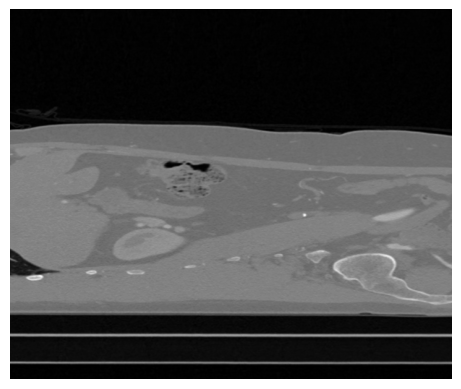

In [25]:
visualize(read_image(imaging_path[200]))

(tensor([[[-0.4626, -0.4626, -0.4626,  ..., -0.4626, -0.4626, -0.4626],
         [-0.4626, -0.4626, -0.4626,  ..., -0.4626, -0.4626, -0.4626],
         [-0.4626, -0.4626, -0.4626,  ..., -0.4626, -0.4626, -0.4626],
         ...,
         [-0.4626, -0.4626, -0.4626,  ..., -0.4626, -0.4626, -0.4626],
         [-0.4626, -0.4626, -0.4626,  ..., -0.4626, -0.4626, -0.4626],
         [-0.4626, -0.4626, -0.4626,  ..., -0.4626, -0.4626, -0.4626]]],
       dtype=torch.float64), tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32))


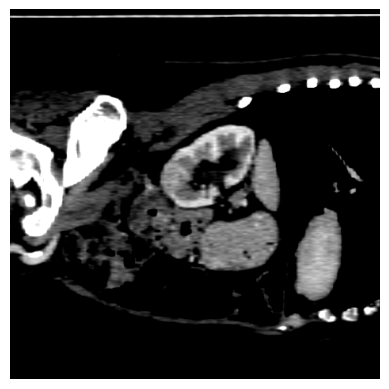

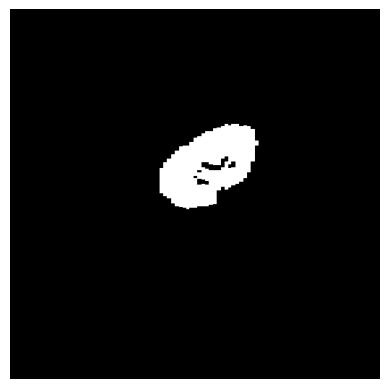

In [26]:
x = train_dataset[15200]
print(train_dataset[200])
visualize(x[0])
visualize(x[1])

In [27]:
image, mask = val_dataset[1000]
image.shape

torch.Size([1, 512, 512])

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
device

device(type='cuda')

In [30]:
# train_data,test_data,val_data=random_split(dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))

# print(len(train_data),len(test_data),len(val_data))  

In [31]:
# train_data,test_data, validation_data=random_split(dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_dataset, 128, shuffle = True, num_workers=4)
test_dataloader = DataLoader(test_dataset, 128, num_workers=4)
val_dataloader = DataLoader(val_dataset, 128, num_workers=4)
# dataset_dataloader = DataLoader(dataset, 128, num_workers=4)


In [32]:
model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=1, classes=1).to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for training.")
    model = torch.nn.DataParallel(model)

Using 2 GPUs for training.


In [33]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
def dice_coefficient(y_true, y_pred):

    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum()
    if union == 0:
        return 1
    return (2. * intersection) / union

def test_model(model, test_dataloader):
    model.eval()
    dice_scores = []
    with torch.no_grad():
        total_loss = 0
        correct = 0
        total = 0
        for images, masks in test_dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images.float())
            predictions = (outputs > 0).float()
            for i in range(len(images)):
                if np.sum(torch.Tensor.cpu(images[i]).numpy()) > 0:
                    # dice = dice_coefficient(predictions[i], masks[i])
                    predictions[i] = predictions[i] * (images[i] != 0)
                    dice = dice_coefficient(predictions[i], masks[i])
                    dice_scores.append(dice)
    # avg_dice = sum(dice_scores) / len(dice_scores)
    return dice_scores

def train_model(model, train_dataloader, val_dataloader, num_epochs, early_stopping):
    best_model_eval = 0
    best_dice = 0
    patience = 0
    with open("Kidney_seg_d0_log13.txt", "a") as f:
        for epoch in range(num_epochs):
            total_loss = 0
            total = 0
            model.train()
            for batch_index, (images, masks) in enumerate(train_dataloader):
                optimizer.zero_grad()
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, masks.float())
                total_loss += loss.item() * images.size(0)
                total += images.size(0)
                loss.backward()
                optimizer.step()

                if batch_index % 10 == 0:
                    loss = total_loss / total
                    print(loss)
            train_loss = total_loss / total

            # Validation
            model.eval()
            with torch.no_grad():
                total_loss = 0
                total = 0
                for images, masks in val_dataloader:
                    images = images.to(device)
                    masks = masks.to(device)
                    outputs = model(images.float())
                    loss = criterion(outputs, masks.float())
                    total_loss += loss.item() * images.size(0)
                    total += images.size(0)
            val_loss = total_loss / total

            dice_scores = test_model(model, val_dataloader)
            dice_score = sum(dice_scores)/ len(dice_scores)
            if dice_score < best_dice or best_dice == 0:
                patience = 0
                best_dice = dice_score
                model_state_dict = model.state_dict()
                torch.save(model_state_dict, 'Kidney_seg_d0_dict13_dice_score.pt')
                print("Saved")
            if val_loss < best_model_eval or best_model_eval == 0:
                patience = 0
                best_model_eval = val_loss
                model_state_dict = model.state_dict()
                torch.save(model_state_dict, 'Kidney_seg_d0_dict13_val_loss.pt')
            # else:
            #     patience += 1

            # if early_stopping and patience == early_stopping:
            #     break 

            f.write(f'Epoch: {epoch} Train Loss: {train_loss} Validation Loss: {val_loss}\n')
            print(f'Epoch: {epoch} Train Loss: {train_loss} Validation Loss: {val_loss}\n')
            # dice_scores = test_model(model, val_dataloader)
            f.write(f'Validation Accuracy: {dice_score}')
            print(f'Validation Accuracy: {dice_score}')

In [35]:
train_model(model, train_dataloader, val_dataloader, 100, None)

0.8409780263900757
0.5286269567229531
0.3925311437674931
0.3202447578791649
0.27300166556747946
0.240662718520445
0.21590623833605502
0.19749806454064142
0.18257292461248092
0.16945368411776784
0.15932169232037988
0.15012759466965994
0.14236161694669527
0.13566829716317527
0.12976652087894738
0.12468670683586044
0.12000493814023386
0.11559946991895374
0.11162728314076997
0.10821982627217683
0.1050115279593871
0.10206304005042637
0.09946580662716568
0.09690609209852301
0.09461153256880792
0.0923733827453923
0.09031853178280523
0.08837205717319492
0.08659724154082057
0.08495826414975104
0.083375599878868
0.0818703784712162
0.08030856791245418
0.07900218196280773
0.07761630656803983
0.07633918244126346
0.07506684457929676
0.07392167340652801
0.0728590739426494
0.07184821499221007
0.07087714893933841
0.06996817035269708
0.06911505650808579
0.06819856745512884
0.06734668283961932
0.06646374387959815
0.06570620612198903
0.06494963730264242
0.06421732124165785
0.0636060877063913
0.06289011462

In [185]:
# model_state_dict = model.state_dict()
# torch.save(model_state_dict, 'model_state_dict2.pt')

In [215]:
model_state_dict = torch.load('seg_model_state_dict8.pt')
# load the state dictionary into the model
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [203]:
dice_scores = test_model(model, test_dataloader)
print(sum(dice_scores)/ len(dice_scores))

tensor(0.9611, device='cuda:0')


In [216]:
# Segment Kidneys
model.eval()
for image, mask, GID, IID in test_dataset:

    image = image.unsqueeze(0).to(device)
    output = model(image.float())
    prediction = torch.Tensor.cpu((output > 0).float())
    real_img = read_image(path_df[(path_df["GID"] == GID) & (path_df["IID"] == IID)]["Image"].iloc[0])
    original_shape = real_img.shape
    resized_tensor = F.interpolate(prediction, size=(original_shape[0], original_shape[1]))
    resized_tensor = resized_tensor.squeeze(0)
    # visualize(resized_tensor)



    # break
#     real_img = general_transform(image=real_img)["image"]
    

#     # print(real_img)
#     # visualize(torch.Tensor.cpu(prediction))
#     kidney_seg = torch.Tensor.cpu(prediction) * real_img
#     # print(kidney_seg)
#     # visualize(torch.Tensor.cpu((kidney_seg)))
    
#     # save data
    root = "kits21/kits21/data"
    directory = "kidney_mask_d3"
    folder = "case_" + (5 - len(str(GID))) * "0" + str(GID)
    path = os.path.join(root + "/" + folder, directory)
    if not os.path.exists(path):
        os.makedirs(path)
    filename = f'kidney_segment_slice_{(5 - len(str(IID))) * "0" + str(IID)}.nii.gz'
    filepath = os.path.join(path, filename)
    print(filepath)
    kidney_mask = sitk.GetImageFromArray(resized_tensor)
#     kidney_seg = torch.Tensor.cpu(kidney_seg).squeeze().numpy()
#     # kidney_seg[kidney_seg < 0] = 0
#     # if GID == 0 and IID == 94:
#     #     visualize(torch.Tensor.cpu(prediction))
#     #     visualize(real_img)
#     #     visualize(kidney_seg)
#     #     break
#     visualize(kidney_seg)
#     kidney_seg = sitk.GetImageFromArray(kidney_seg)
#     # visualize(kidney_seg)
    sitk.WriteImage(kidney_mask, filepath)
    
#     # visualize(kidney_seg)


# img, mask, GID, IID = test_dataset[200]


# x = read_image(path_df[(path_df["GID"] == GID) & (path_df["IID"] == IID)]["Image"].iloc[0])
# orginal_shape = x.shape
# visualize(test_dataset[200][0])
# resized_tensor = F.interpolate(test_dataset[200][0].unsqueeze(0), size=(orginal_shape[0], orginal_shape[1]))
# visualize(resized_tensor.squeeze(0))
# visualize(x)
# np.array_equal(x.astype(int), np.array(resized_tensor.astype(int))

kits21/kits21/data/case_00270/kidney_mask_d3/kidney_segment_slice_00000.nii.gz
kits21/kits21/data/case_00270/kidney_mask_d3/kidney_segment_slice_00001.nii.gz
kits21/kits21/data/case_00270/kidney_mask_d3/kidney_segment_slice_00002.nii.gz
kits21/kits21/data/case_00270/kidney_mask_d3/kidney_segment_slice_00003.nii.gz
kits21/kits21/data/case_00270/kidney_mask_d3/kidney_segment_slice_00004.nii.gz
kits21/kits21/data/case_00270/kidney_mask_d3/kidney_segment_slice_00005.nii.gz
kits21/kits21/data/case_00270/kidney_mask_d3/kidney_segment_slice_00006.nii.gz
kits21/kits21/data/case_00270/kidney_mask_d3/kidney_segment_slice_00007.nii.gz
kits21/kits21/data/case_00270/kidney_mask_d3/kidney_segment_slice_00008.nii.gz
kits21/kits21/data/case_00270/kidney_mask_d3/kidney_segment_slice_00009.nii.gz
kits21/kits21/data/case_00270/kidney_mask_d3/kidney_segment_slice_00010.nii.gz
kits21/kits21/data/case_00270/kidney_mask_d3/kidney_segment_slice_00011.nii.gz
kits21/kits21/data/case_00270/kidney_mask_d3/kidney_

KeyError: 8410

In [243]:
root = "kits21/kits21/data"
predicted_kidney_d3_path = sorted(glob.glob(f'{root}/**/kidney_mask_d3/*.nii.gz', recursive=True))
annotation_d3_path = sorted(glob.glob(f'{root}/**/annotations/*.nii.gz', recursive=True))

predicted_kidney_d0_path = sorted(glob.glob(f'{root}/**/kidney_mask_d0/*.nii.gz', recursive=True))
annotation_d0_path = sorted(glob.glob(f'{root}/**/Kidney_Annotation_d0/*.nii.gz', recursive=True))

kidney_masks_d3_df = create_df(predicted_kidney_d3_path, annotation_d3_path)
kidney_masks_d0_df = create_df(predicted_kidney_d0_path, annotation_d0_path)

kidney_masks_d3_dataset = ImageDataset(kidney_masks_d3_df, return_id=True)
kidney_masks_d0_dataset = ImageDataset(kidney_masks_d0_df, return_id=True)

In [275]:
root = "kits21/kits21/data"
labels_path = sorted(glob.glob(f'{root}/Segmentation/**'), reverse=False)

# labels_path.sort(reverse=True)

labels_path

['kits21/kits21/data/Segmentation/kidney_annotation_case_00000.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00001.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00002.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00003.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00004.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00005.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00006.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00007.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00008.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00009.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00010.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00011.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00012.nii.gz',
 'kits21/kits21/data/Segmentation/kidney_annotation_case_00013.n

In [288]:
dice_scores = []

for GID in range(270, 300):

    label = read_image(labels_path[GID])

    kidney_masks_d3_df
    df_per_GID = kidney_masks_d3_df[(kidney_masks_d3_df["GID"] == GID)]
    # df_per_GID["Image"].iloc[]
    slices_d3 = []
    for path in df_per_GID["Image"]:
        slices_d3.append(read_image(path).squeeze())
    numpy_array_d3 = np.array(slices_d3)

    df_per_GID = kidney_masks_d0_df[(kidney_masks_d0_df["GID"] == GID)]
    slices_d0 = []
    for path in df_per_GID["Image"]:
        slices_d0.append(read_image(path).squeeze())
    numpy_array_d0 = np.array(slices_d0)

    numpy_array_d3 = np.transpose(numpy_array_d3, axes=(1, 2, 0))
    print(numpy_array_d0.shape)
    print(numpy_array_d3.shape)
    print(label.shape)

    sum_of_arrays = numpy_array_d3 + numpy_array_d0

    dice = dice_coefficient(numpy_array_d3, label)
    dice_scores.append(dice)


# real_img = read_image(path_df[(path_df["GID"] == GID) & (path_df["IID"] == IID)]["Image"].iloc[0])
print(dice_scores)
print(sum(dice_scores)/ len(dice_scores))

(512, 512, 93)
(512, 512, 93)
(512, 512, 93)
(512, 512, 468)
(512, 512, 468)
(512, 512, 468)
(512, 512, 673)
(512, 512, 673)
(512, 512, 673)
(512, 512, 238)
(512, 512, 238)
(512, 512, 238)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 94)
(512, 512, 94)
(512, 512, 94)
(512, 512, 727)
(512, 512, 727)
(512, 512, 727)
(512, 512, 79)
(512, 512, 79)
(512, 512, 79)
(512, 512, 165)
(512, 512, 165)
(512, 512, 165)
(512, 512, 60)
(512, 512, 60)
(512, 512, 60)
(512, 512, 79)
(512, 512, 79)
(512, 512, 79)
(512, 512, 266)
(512, 512, 266)
(512, 512, 266)
(512, 512, 86)
(512, 512, 86)
(512, 512, 86)
(512, 512, 337)
(512, 512, 337)
(512, 512, 337)
(512, 512, 244)
(512, 512, 244)
(512, 512, 244)
(512, 512, 41)
(512, 512, 41)
(512, 512, 41)
(512, 512, 106)
(512, 512, 106)
(512, 512, 106)
(512, 512, 54)
(512, 512, 54)
(512, 512, 54)
(512, 512, 276)
(512, 512, 276)
(512, 512, 276)
(512, 512, 86)
(512, 512, 86)
(512, 512, 86)
(512, 512, 683)
(512, 512, 683)
(512, 512, 683)
(512, 512, 131)
(51

(512, 512, 93)

In [240]:
kidney_masks_d0_df

,GID,IID,Image,Mask
0,270,0,kits21/kits21/data/case_00270/kidney_mask_d0/k...,kits21/kits21/data/case_00000/Kidney_Annotatio...
1,270,1,kits21/kits21/data/case_00270/kidney_mask_d0/k...,kits21/kits21/data/case_00000/Kidney_Annotatio...
2,270,2,kits21/kits21/data/case_00270/kidney_mask_d0/k...,kits21/kits21/data/case_00000/Kidney_Annotatio...
3,270,3,kits21/kits21/data/case_00270/kidney_mask_d0/k...,kits21/kits21/data/case_00000/Kidney_Annotatio...
4,270,4,kits21/kits21/data/case_00270/kidney_mask_d0/k...,kits21/kits21/data/case_00000/Kidney_Annotatio...
...,...,...,...,...
15355,299,507,kits21/kits21/data/case_00299/kidney_mask_d0/k...,kits21/kits21/data/case_00029/Kidney_Annotatio...
15356,299,508,kits21/kits21/data/case_00299/kidney_mask_d0/k...,kits21/kits21/data/case_00029/Kidney_Annotatio...
15357,299,509,kits21/kits21/data/case_00299/kidney_mask_d0/k...,kits21/kits21/data/case_00029/Kidney_Annotatio...
15358,299,510,kits21/kits21/data/case_00299/kidney_mask_d0/k...,kits21/kits21/data/case_00029/Kidney_Annotatio...


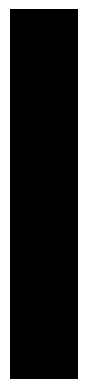

In [229]:
read_image(kidney_mask_d0_path[40])

In [ ]:
model.eval()
for image, mask in test_dataset:
    image = image.unsqueeze(0).to(device)
    output = model(image.float())
    prediction = (output > 0).float()
    kidney_seg = prediction * image
    print("tumor seg")
    visualize(torch.Tensor.cpu((kidney_seg)))
    print("real data")
    visualize(torch.Tensor.cpu((image)))

In [ ]:
# root = "kits21/kits21/data"
  
# directory = "Tumor_Segmentation_annotations"

# path = os.path.join(root, directory)

# os.mkdir(path)

In [ ]:
# labels_path = sorted(glob.glob(f'{root}/**/aggregated_MAJ**', recursive=True))

# labels_path

In [ ]:
# for i in range(len(labels_path)):
#     image_array = read_image(labels_path[i])
#     image_array[image_array != 2] = 0
#     image_array[image_array > 0] = 1
#     image = sitk.GetImageFromArray(image_array)

#     sitk.WriteImage(image, f'{root}/{directory}/Tumor_annotation_case_{(5 - len(str(i))) * "0" + str(i)}.nii.gz')

In [ ]:
# root = "kits21/kits21/data"
# labels_path = sorted(glob.glob(f'{root}/{directory}/*.nii.gz'), reverse=False)

# # labels_path.sort(reverse=True)

# labels_path

In [ ]:
# # converting 3d annotations to 2d slices for masks
# for i in range(len(labels_path)):
#     image = read_image(labels_path[i])
#     for j in range(image.shape[2]):
#         image_slice = sitk.GetImageFromArray(image[:,:,j])

#         root = "kits21/kits21/data"
#         directory = "tumor_annotations"
#         folder = "case_" + (5 - len(str(i))) * "0" + str(i)
#         path = os.path.join(root + "/" + folder, directory)
#         if not os.path.exists(path):
#             os.makedirs(path)
#         filename = f'tumor_annotation_slice_{(5 - len(str(j))) * "0" + str(j)}.nii.gz'
#         filepath = os.path.join(path, filename)
#         print(filepath)
#         sitk.WriteImage(image_slice, filepath)

In [ ]:
img = read_image(images_path[0])
for i in range(len(img[2])):
    image = img[:,:,i]
    image = general_transform

In [ ]:
# Segment Kidneys
model.eval()
for image, mask, GID, IID in dataset:

    image = image.unsqueeze(0).to(device)
    output = model(image.float())
    prediction = (output > 0).float()
    real_img = read_image(path_df[(path_df["GID"] == GID) & (path_df["IID"] == IID)]["Image"].iloc[0])
    real_img = general_transform(image=real_img)["image"]
    

    # print(real_img)
    # visualize(torch.Tensor.cpu(prediction))
    kidney_seg = torch.Tensor.cpu(prediction) * real_img
    # print(kidney_seg)
    # visualize(torch.Tensor.cpu((kidney_seg)))
    
    # save data
    root = "kits21/kits21/data"
    directory = "kidney_segment"
    folder = "case_" + (5 - len(str(GID))) * "0" + str(GID)
    path = os.path.join(root + "/" + folder, directory)
    if not os.path.exists(path):
        os.makedirs(path)
    filename = f'kidney_segment_slice_{(5 - len(str(IID))) * "0" + str(IID)}.nii.gz'
    filepath = os.path.join(path, filename)
    print(filepath)
    kidney_seg = torch.Tensor.cpu(kidney_seg).squeeze().numpy()
    # kidney_seg[kidney_seg < 0] = 0
    # if GID == 0 and IID == 94:
    #     visualize(torch.Tensor.cpu(prediction))
    #     visualize(real_img)
    #     visualize(kidney_seg)
    #     break
    visualize(kidney_seg)
    kidney_seg = sitk.GetImageFromArray(kidney_seg)
    # visualize(kidney_seg)
    sitk.WriteImage(kidney_seg, filepath)
    
    # visualize(kidney_seg)

In [ ]:
# # This code is for removing folders
# import shutil

# for i in range(300): 
#     root = "kits21/kits21/data"
#     directory = "kidney_segment"
#     folder = "case_" + (5 - len(str(i))) * "0" + str(i)
#     path = os.path.join(root + "/" + folder, directory)
#     shutil.rmtree(path)

In [4]:
root = "kits21/kits21/data"
directory = "kidney_segment"
kidney_segments_path = sorted(glob.glob(f'{root}/**/{directory}/*.nii.gz', recursive=True))

kidney_segments_path

['kits21/kits21/data/case_00000/kidney_segment/kidney_segment_slice_00000.nii.gz',
 'kits21/kits21/data/case_00000/kidney_segment/kidney_segment_slice_00001.nii.gz',
 'kits21/kits21/data/case_00000/kidney_segment/kidney_segment_slice_00002.nii.gz',
 'kits21/kits21/data/case_00000/kidney_segment/kidney_segment_slice_00003.nii.gz',
 'kits21/kits21/data/case_00000/kidney_segment/kidney_segment_slice_00004.nii.gz',
 'kits21/kits21/data/case_00000/kidney_segment/kidney_segment_slice_00005.nii.gz',
 'kits21/kits21/data/case_00000/kidney_segment/kidney_segment_slice_00006.nii.gz',
 'kits21/kits21/data/case_00000/kidney_segment/kidney_segment_slice_00007.nii.gz',
 'kits21/kits21/data/case_00000/kidney_segment/kidney_segment_slice_00008.nii.gz',
 'kits21/kits21/data/case_00000/kidney_segment/kidney_segment_slice_00009.nii.gz',
 'kits21/kits21/data/case_00000/kidney_segment/kidney_segment_slice_00010.nii.gz',
 'kits21/kits21/data/case_00000/kidney_segment/kidney_segment_slice_00011.nii.gz',
 'ki

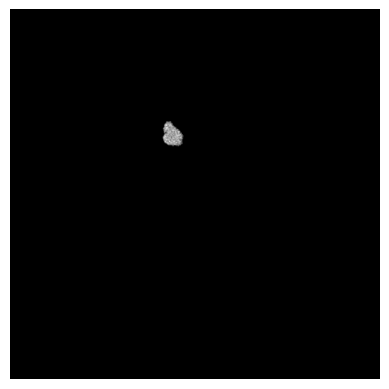

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [5]:
visualize(read_image(kidney_segments_path[5000]))
read_image(kidney_segments_path[93])

In [6]:
root = "kits21/kits21/data"
directory = "tumor_annotations"
tumor_annotations_path = sorted(glob.glob(f'{root}/**/{directory}/*.nii.gz', recursive=True))

tumor_annotations_path

['kits21/kits21/data/case_00000/tumor_annotations/tumor_annotation_slice_00000.nii.gz',
 'kits21/kits21/data/case_00000/tumor_annotations/tumor_annotation_slice_00001.nii.gz',
 'kits21/kits21/data/case_00000/tumor_annotations/tumor_annotation_slice_00002.nii.gz',
 'kits21/kits21/data/case_00000/tumor_annotations/tumor_annotation_slice_00003.nii.gz',
 'kits21/kits21/data/case_00000/tumor_annotations/tumor_annotation_slice_00004.nii.gz',
 'kits21/kits21/data/case_00000/tumor_annotations/tumor_annotation_slice_00005.nii.gz',
 'kits21/kits21/data/case_00000/tumor_annotations/tumor_annotation_slice_00006.nii.gz',
 'kits21/kits21/data/case_00000/tumor_annotations/tumor_annotation_slice_00007.nii.gz',
 'kits21/kits21/data/case_00000/tumor_annotations/tumor_annotation_slice_00008.nii.gz',
 'kits21/kits21/data/case_00000/tumor_annotations/tumor_annotation_slice_00009.nii.gz',
 'kits21/kits21/data/case_00000/tumor_annotations/tumor_annotation_slice_00010.nii.gz',
 'kits21/kits21/data/case_00000/

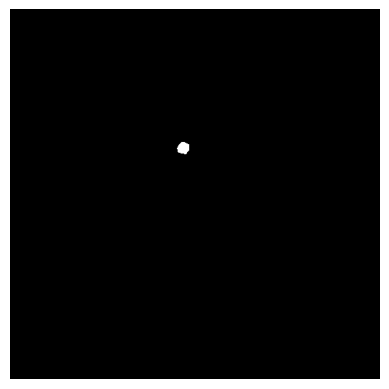

In [7]:
visualize(read_image(tumor_annotations_path[5000]))

In [8]:
tumor_seg_df = create_df(kidney_segments_path, tumor_annotations_path)
tumor_seg_df

,GID,IID,Image,Mask
0,0,0,kits21/kits21/data/case_00000/kidney_segment/k...,kits21/kits21/data/case_00000/tumor_annotation...
1,0,1,kits21/kits21/data/case_00000/kidney_segment/k...,kits21/kits21/data/case_00000/tumor_annotation...
2,0,2,kits21/kits21/data/case_00000/kidney_segment/k...,kits21/kits21/data/case_00000/tumor_annotation...
3,0,3,kits21/kits21/data/case_00000/kidney_segment/k...,kits21/kits21/data/case_00000/tumor_annotation...
4,0,4,kits21/kits21/data/case_00000/kidney_segment/k...,kits21/kits21/data/case_00000/tumor_annotation...
...,...,...,...,...
65159,299,619,kits21/kits21/data/case_00299/kidney_segment/k...,kits21/kits21/data/case_00299/tumor_annotation...
65160,299,620,kits21/kits21/data/case_00299/kidney_segment/k...,kits21/kits21/data/case_00299/tumor_annotation...
65161,299,621,kits21/kits21/data/case_00299/kidney_segment/k...,kits21/kits21/data/case_00299/tumor_annotation...
65162,299,622,kits21/kits21/data/case_00299/kidney_segment/k...,kits21/kits21/data/case_00299/tumor_annotation...


In [9]:
tumor_seg_train_df = tumor_seg_df[tumor_seg_df['GID'] < 240].reset_index(drop=True)
tumor_seg_val_df = tumor_seg_df[(tumor_seg_df['GID'] >= 240) & (tumor_seg_df['GID'] < 270)].reset_index(drop=True)
tumor_seg_test_df = tumor_seg_df[tumor_seg_df['GID'] >= 270].reset_index(drop=True)

print(len(tumor_seg_train_df),len(tumor_seg_val_df),len(tumor_seg_test_df))  

51023 5731 8410


In [10]:
# mean = 0
# std = 0
# for path in tumor_seg_train_df["Image"]:
#     image = sitk.ReadImage(path)
#     image_array = sitk.GetArrayFromImage(image)
#     mean += np.mean(image_array)
#     std += np.std(image_array)
# mean = mean/len(kidney_segments_path)
# std = std/len(kidney_segments_path)

# print(mean)
# print(std)

In [11]:
mean = 0.664273895576416
std = 4.725413867915321

# Define the transformation pipeline
image_transform = transforms.Compose([
    transforms.Normalize(mean=mean, std=std) # Normalize the tensor
])

# Define the transformation pipeline - this will be used for both image and mask
general_transform = A.Compose([
    A.Resize(height=512, width=512),
    ToTensorV2()
    # transforms.RandomHorizontalFlip(0.2)
])
random_transform = A.Compose([
    A.Rotate(limit=(-30, 30), border_mode=0, p=0.3),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.GaussNoise(p=0.5),
    A.RandomCrop(width=380, height=380, p=0.5)
])

In [12]:
tumor_seg_train_dataset = ImageDataset(tumor_seg_train_df, image_transform, general_transform, random_transform, None)
tumor_seg_val_dataset = ImageDataset(tumor_seg_val_df, image_transform, general_transform, None, None)
tumor_seg_test_dataset = ImageDataset(tumor_seg_test_df, image_transform, general_transform, None, True)

(tensor([[[-0.1406, -0.1406, -0.1406,  ..., -0.1406, -0.1406, -0.1406],
         [-0.1406, -0.1406, -0.1406,  ..., -0.1406, -0.1406, -0.1406],
         [-0.1406, -0.1406, -0.1406,  ..., -0.1406, -0.1406, -0.1406],
         ...,
         [-0.1406, -0.1406, -0.1406,  ..., -0.1406, -0.1406, -0.1406],
         [-0.1406, -0.1406, -0.1406,  ..., -0.1406, -0.1406, -0.1406],
         [-0.1406, -0.1406, -0.1406,  ..., -0.1406, -0.1406, -0.1406]]],
       dtype=torch.float64), tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32))


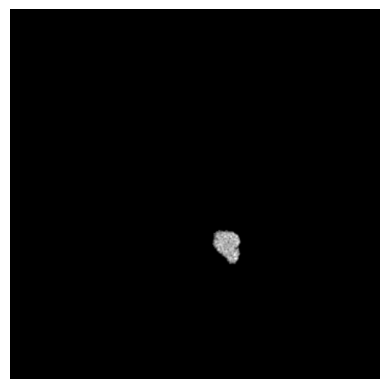

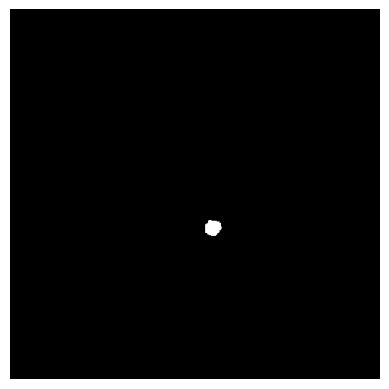

In [13]:
x = tumor_seg_train_dataset[5000]
print(tumor_seg_train_dataset[5000])
# image = x[0]
# image[image < 0] = 0
# print(image)

visualize(x[0])
visualize(x[1])

In [14]:
tumor_seg_train_dataloader = DataLoader(tumor_seg_train_dataset, 128, shuffle = True, num_workers=4)
# tumor_seg_test_dataloader = DataLoader(tumor_seg_test_dataset, 128, num_workers=4)
tumor_seg_val_dataloader = DataLoader(tumor_seg_val_dataset, 128, num_workers=4)


In [27]:
for images, masks, GID, IID in tumor_seg_test_dataloader:
    for image in images:
        visualize(image)
        print(image)
    break

NameError: name 'tumor_seg_test_dataloader' is not defined

In [29]:
class ImprovedConvAutoencoder(nn.Module):
    def __init__(self):
        super(ImprovedConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

improved_conv_autoencoder = 0

In [18]:

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.conv(dec1)

Unet_model = UNet(1, 1)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# def dice_loss(y_pred, y_true, smooth=1):
#     intersection = torch.sum(y_pred * y_true)
#     union = torch.sum(y_pred) + torch.sum(y_true)
#     dice = (2 * intersection + smooth) / (union + smooth)
#     return 1 - dice

tumor_seg_model = smp.Unet("resnet34", in_channels=1, classes=1).to(device)
# tumor_seg_model = improved_conv_autoencoder.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for training.")
    tumor_seg_model = torch.nn.DataParallel(tumor_seg_model)
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = dice_loss

optimizer = torch.optim.Adam(tumor_seg_model.parameters(), lr=0.001)

# tumor_seg_model = Unet_model.to(device)
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs for training.")
#     tumor_seg_model = torch.nn.DataParallel(tumor_seg_model)
# criterion = nn.BCEWithLogitsLoss()






# optimizer = torch.optim.Adam(tumor_seg_model.parameters(), lr=0.001)

Using 2 GPUs for training.


In [24]:
train_model(tumor_seg_model, tumor_seg_train_dataloader, tumor_seg_val_dataloader, 100, 0)

OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/student/hosein/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home/student/hosein/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/student/hosein/anaconda3/lib/python3.9/site-packages/segmentation_models_pytorch/base/model.py", line 30, in forward
    decoder_output = self.decoder(*features)
  File "/home/student/hosein/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/student/hosein/anaconda3/lib/python3.9/site-packages/segmentation_models_pytorch/decoders/unet/decoder.py", line 119, in forward
    x = decoder_block(x, skip)
  File "/home/student/hosein/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/student/hosein/anaconda3/lib/python3.9/site-packages/segmentation_models_pytorch/decoders/unet/decoder.py", line 40, in forward
    x = self.conv1(x)
  File "/home/student/hosein/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/student/hosein/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py", line 204, in forward
    input = module(input)
  File "/home/student/hosein/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/student/hosein/anaconda3/lib/python3.9/site-packages/torch/nn/modules/batchnorm.py", line 171, in forward
    return F.batch_norm(
  File "/home/student/hosein/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py", line 2450, in batch_norm
    return torch.batch_norm(
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 47.54 GiB total capacity; 44.93 GiB already allocated; 148.81 MiB free; 45.90 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [31]:
tumor_seg_test_dataloader = DataLoader(tumor_seg_test_dataset, 32, num_workers=4)

In [21]:
model_state_dict = torch.load('Tumor_seg_model_state_dict8.pt')
# load the state dictionary into the model
tumor_seg_model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [22]:
tumor_seg_test_dataset = ImageDataset(tumor_seg_test_df, image_transform, general_transform, None, None)
tumor_seg_test_dataloader = DataLoader(tumor_seg_test_dataset, 32, num_workers=4)

In [23]:
dice_scores = test_model(tumor_seg_model, tumor_seg_val_dataloader)
print(sum(dice_scores)/ len(dice_scores))

tensor(0.8117, device='cuda:0')


In [ ]:
tumor_seg_model.eval()
for image, mask, GID, IID in tumor_seg_test_dataset:
    image = image.unsqueeze(0).to(device)
    output = tumor_seg_model(image.float())
    prediction = (output > 0).float()
    kidney_seg = prediction * image
    
    image = torch.Tensor.cpu((image))
    prediction = torch.Tensor.cpu((prediction))


    print("real data", IID)
    visualize(mask)

    print("tumor seg", IID)
    visualize(prediction*(image!=0))
  
    


In [ ]:
# Convert 2D slices to 3D
def convert_2D_to_3D(slices, GID):
    img = sitk.ReadImage(images_path[GID])

    # Create an empty 3D array
    image_shape = list(slices[0].GetSize()) + [len(slices)]
    image_array = np.zeros(image_shape)

    # Loop through each 2D image and insert it into the 3D array
    for i, image in enumerate(slices):
        image_array[:,:,i] = sitk.GetArrayFromImage(image)

    # Create a SimpleITK image from the 3D array
    output_image = sitk.GetImageFromArray(image_array)

    # Set the spacing, origin, and direction of the 3D volume
    output_image.SetSpacing(img.GetSpacing())
    output_image.SetOrigin(img.GetOrigin())
    output_image.SetDirection(img.GetDirection())

    return output_image

In [ ]:
image_GID = 295
slices = []
kidney_seg = []
tumor_seg_model.eval()
for image, mask, GID, IID in tumor_seg_test_dataset:
    if GID == image_GID:
        print(f'GID: {GID} IID: {IID}')
        image = image.unsqueeze(0).to(device)
        output = tumor_seg_model(image.float())
        prediction = (output > 0).float()
        tumor_seg = prediction * image
        # print("tumor seg")
        # visualize(torch.Tensor.cpu((kidney_seg)))
        # print("real data")
        # visualize(torch.Tensor.cpu((mask)))
        # visualize(torch.Tensor.cpu(tumor_seg).squeeze(0).squeeze(0).numpy())
        slice_img = sitk.GetImageFromArray(torch.Tensor.cpu(tumor_seg).squeeze(0).squeeze(0).numpy())
        slices.append(slice_img)
        # kidney_seg_slice = sitk.GetImageFromArray(torch.Tensor.cpu(image))
        # visualize(torch.Tensor.cpu(image))
        # kidney_seg.append(kidney_seg_slice)

        root = "kits21/kits21/data"
        directory = "Tumor_Seg"
        folder = "case_" + (5 - len(str(GID))) * "0" + str(GID)
        path = os.path.join(root + "/" + folder, directory)
        if not os.path.exists(path):
            os.makedirs(path)
        filename = f'Tumor_segment_slice_{(5 - len(str(IID))) * "0" + str(IID)}.nii.gz'
        filepath = os.path.join(path, filename)
        print(filepath)
        # kidney_seg[kidney_seg < 0] = 0
        # if GID == 0 and IID == 94:
        #     visualize(torch.Tensor.cpu(prediction))
        #     visualize(real_img)
        #     visualize(kidney_seg)
        #     break
        # visualize(kidney_seg)
        sitk.WriteImage(slice_img, filepath)


In [ ]:
my_image = convert_2D_to_3D(slices, image_GID)
# my_image = convert_2D_to_3D(kidney_seg, image_GID)

sitk.WriteImage(my_image, f'298_Tumor_seg.nii.gz')

In [ ]:
visualize(my_image[187])